# Posterior Inference

@author: Yi, Jul 26 2020

本文介绍后验计算中的常见问题，以及 MCMC/VI 的使用，部分代码改编自[Ritchie Vink的博客](https://www.ritchievink.com/blog/2019/06/10/bayesian-inference-how-we-are-able-to-chase-the-posterior/)。

## Tractable Posterior

依赖： `scipy`

定义一个数据集 $D$，包含两个篮球运动员的身高 195、185。

为了拟合这个数据，假设符合高斯分布 $N(\mu, \sigma)$。同时，假设 $\mu$ 在 (150, 250) 之间， $\sigma$ 在 (0, 15) 之间。

对于所有可能的参数，计算数据集的似然 $L(D | \mu, \sigma)$ ，然后观察到最优参数。

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

lengths = np.array([195, 185])

mu = np.linspace(150, 250, num=50)
sigma = np.linspace(0, 15, num=50)[::-1]

# 创建 50x50 的网格点
mm, ss = np.meshgrid(mu, sigma)

绘制出 likelihood 的网格图，每个点对应的其实是 $p(D | \mu, \sigma)$

Text(0, 0.5, '$\\sigma$')

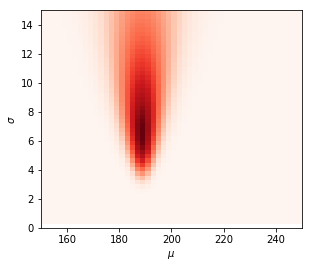

In [53]:
# 对于每个 (mu, sigma)，创建一个高斯分布。
# dist 是 50x50 个高斯分布。
dist = stats.norm(mm, ss)
# likelihood 是 50x50 的矩阵，每个位置代表一组参数的高斯分布的似然。
likelihood = dist.pdf(lengths[0]) * dist.pdf(lengths[1])

aspect = mm.max() / ss.max() / 3
extent = [mm.min(), mm.max(), ss.min(), ss.max()]

plt.imshow(likelihood, cmap='Reds', aspect=aspect, extent=extent)
plt.xlabel('$\mu$')
plt.ylabel('$\sigma$')

假设参数本身具有一个先验，其中 $\mu \sim N(200, 15), \sigma \sim Cauchy(0, 10)$。

后文中的所有方法都基于此假设。

Text(0, 0.5, '$\\sigma$')

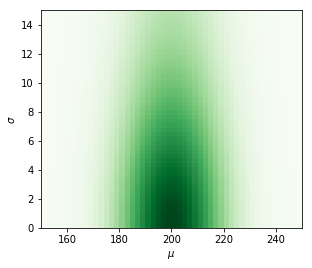

In [54]:
prior = stats.norm(200, 15).pdf(mm) * stats.cauchy(0, 10).pdf(ss)

plt.imshow(prior, cmap='Greens', aspect=aspect, extent=extent)
plt.xlabel('$\mu$')
plt.ylabel('$\sigma$')

根据贝叶斯公式，$p(\theta | D) = p(\theta, D) / p(D) \propto p(\theta) * p(D | \theta)$

- 先计算出参数和数据集的联合分布 $p(\theta, D)$

- 再将参数积分求出 $p(D)$，归一化得到后验分布（对于 trackable 的分布，是可以计算出来的。此处为了方便，假设参数空间在给定的 50x50 的参数网格中，因此直接求和即可。）

Text(0, 0.5, '$\\sigma$')

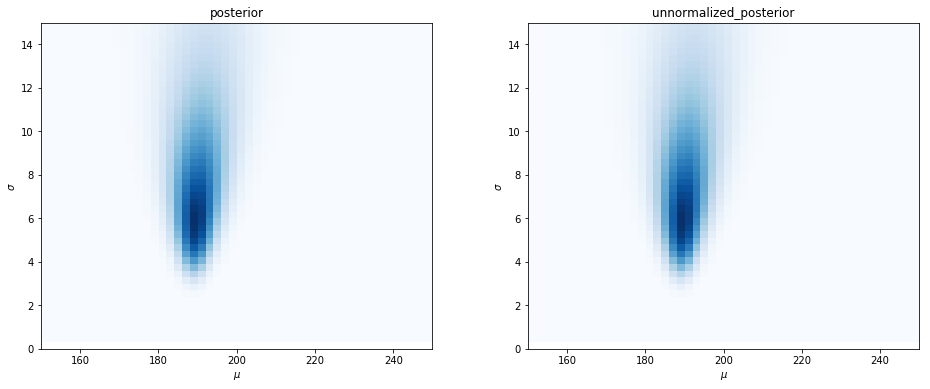

In [65]:
unnormalized_posterior = prior * likelihood
z = np.nan_to_num(unnormalized_posterior).sum()
posterior = unnormalized_posterior / z

fig, axes = plt.subplots(2, sharex=True, sharey=True, figsize = (16, 6))

ax = plt.subplot(1, 2, 1)
ax.imshow(posterior, cmap='Blues', aspect=aspect, extent=extent)
ax.set_title("posterior")
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')

ax = plt.subplot(1, 2, 2)
ax.set_title("unnormalized_posterior")
ax.imshow(unnormalized_posterior, cmap='Blues', aspect=aspect, extent=extent)
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')

## Intractable Posterior

从上图可以看出，分母并不重要，但是分母难以计算。因此需要寻找方法绕过分母的计算，以计算后验。

两种方法：

- 基于采样：MCMC，马尔可夫蒙特卡洛

- 基于优化：VI，变分推断

### Markov Chain Monte Carlo

依赖：`pymc3`

MCMC 方法可以在定义了参数的先验和给定参数下数据的似然下，**从后验分布中进行采样**。

MCMC 的核心思想：前面求分母时，穷举了所有可能的参数。MCMC 则是在参数空间中随机游走，但是游走不是随便游走——否则就和数据本身的分布没啥关系了，因此需要使用与数据相关的概率对参数游走进行约束。

- 随机游走：在参数空间中随便定义一个参数转移的概率 $q(\theta \rightarrow \theta')$。
- 来自数据的约束：每次在 $q$ 里采样时，按照 $min(1, \frac{p(\theta')p(D | \theta'))}{p(\theta)p(D | \theta)}$) 决定是否转移。 
- 每次参数转移都记录下来，得到一堆参数，就是参数的后验分布。

注意：
- $q$ 只是决定了 MCMC 是否高效：越高效的 $q$ 可以得到接受率越高的 $\theta'$。所以下面的代码里并没有定义 $q$。

In [31]:
import pymc3 as pm
with pm.Model():
    # 模型参数的先验: mu~Normal(200, 15), sigma~Cauchy(0, 10)，和前面说的一样。
    mu = pm.Normal('mu', mu=200, sd=15)
    sigma = pm.HalfCauchy('sigma', 10)
    
    # 似然
    observed = pm.Normal('observed', mu=mu, sd=sigma, observed=lengths)
    # sample
    trace = pm.sample(draws=10000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, mu]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 8 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


(0, 15.0)

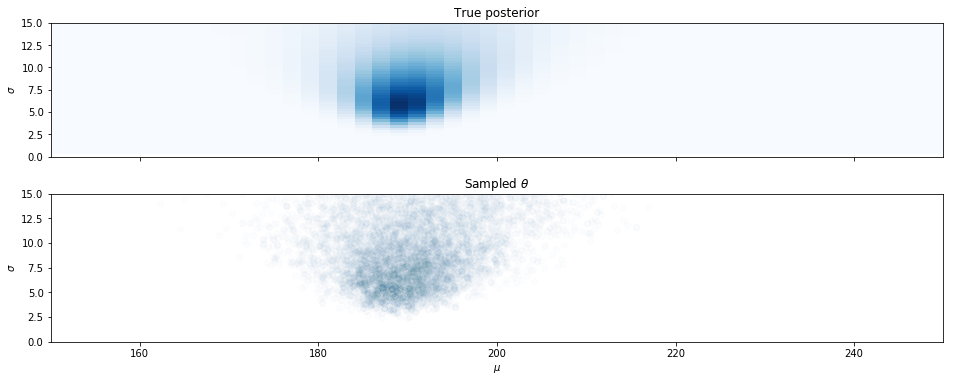

In [32]:
fig, axes = plt.subplots(2, sharex=True, sharey=True, figsize = (16, 6))
axes[0].imshow(posterior, cmap='Blues', extent=extent, aspect=1)
axes[0].set_ylabel('$\sigma$')
axes[1].scatter(trace['mu'], trace['sigma'], alpha=0.01)
axes[1].set_ylabel('$\sigma$')
axes[0].set_title('True posterior')
axes[1].set_title('Sampled $\\theta$')
plt.xlabel('$\mu$')
plt.xlim(150, mm.max())
plt.ylim(0, ss.max())

### variational inference
依赖：`pyro`

对于小的数据集、少的参数， MCMC 还是非常给力的。如果数据多、参数大，MCMC 的效率会非常低。

MCMC 得到的是无偏的后验，代价是速度慢。

但是如果我们对后验的形式进行某种假设，用一个简单的概率分布形式 $q(\theta)$ 来代替后验，然后使得 $KL(q(\theta) \| p(\theta | D))$ 很小就好了。

- 优点：
  - 不用采样，而是直接使用优化的方法来求出 $q(\theta)$，速度 excited。
- 缺点：
  - $q(\theta)$ 毕竟是我们自己随便设计出来的，不一定就是真实数据的后验。
  - 一般会假设 $q(\theta)=q_1(\theta_1)q_2(\theta_2)...$，也就是参数之间是独立的，实际上参数之间未必独立。

In [72]:
import pyro
import pyro.optim
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
import torch
import torch.distributions.constraints as constraints

# --------------------
# 定义一个概率模型：
#    模型参数的先验: mu~Normal(200, 15), sigma~Cauchy(0, 10)，和前面说的一样。
#    数据的似然: Normal(mu, sigma)
# 我们想知道的是这个模型参数的后验：
#    注意参数的后验不一定和先验的形式一致，除非先验分布是似然的共轭分布
# --------------------
def model():
    # priors
    mu = pyro.sample('mu', dist.Normal(loc=torch.tensor(200.), 
                                       scale=torch.tensor(15.)))
    sigma = pyro.sample('sigma', dist.HalfCauchy(scale=torch.tensor(10.)))
    
    # likelihood
    with pyro.plate('plate', size=2):
        pyro.sample(f'obs', dist.Normal(loc=mu, scale=sigma), 
                    obs=torch.tensor([195., 185.]))

# --------------------
# 也不知道后验长啥样，自己瞎**设计一个参数的分布 q:
#    mu~Normal
#    sigma~Chi2/Normal/Cauchy
# 随便设计，不同的分布得出不同的结果
# --------------------
def guide():
    # 假设 mu 的分布是正态分布
    var_mu = pyro.param('var_mu', torch.tensor(180.))
    var_mu_sig = pyro.param('var_mu_sig', torch.tensor(5.),
                             constraint=constraints.positive)
    pyro.sample('mu', dist.Normal(loc=var_mu, scale=var_mu_sig))

    # 假设 sigma 的分布是卡方分布
    # var_sig = pyro.param('var_sig', torch.tensor(5.))
    # pyro.sample('sigma', dist.Chi2(var_sig))

    # 假设 sigma 的分布是正态分布
    # var_sig = pyro.param('var_sig', torch.tensor(8.))
    # var_sig_sig = pyro.param('var_sig_sig', torch.tensor(2.),
    #                          constraint=constraints.positive)
    # pyro.sample('sigma', dist.Normal(loc=var_sig, scale=var_sig_sig))

    # 假设 sigma 的分布是柯西分布
    var_sig = pyro.param('var_sig', torch.tensor(8.))
    pyro.sample('sigma', dist.HalfCauchy(scale=var_sig))

# --------------------
# 用梯度下降最小化 KL(Q|P)，等效于最大化 ELBO
# --------------------
pyro.clear_param_store()
pyro.enable_validation(True)

svi = SVI(model, 
          guide, 
          optim=pyro.optim.ClippedAdam({"lr":0.01}), 
          loss=Trace_ELBO())

c = 0
for step in range(5000):
    c += 1
    loss = svi.step()
    if step % 500 == 0:
        print("[iteration {:>4}] loss: {:.4f}".format(c, loss))

[iteration    1] loss: 12.2714
[iteration  501] loss: 283622.7084
[iteration 1001] loss: 8.8068
[iteration 1501] loss: 9.4706
[iteration 2001] loss: 9.3710
[iteration 2501] loss: 8.9830
[iteration 3001] loss: 10.2023
[iteration 3501] loss: 7.8112
[iteration 4001] loss: 8.2464
[iteration 4501] loss: 12.3706


(0, 15.0)

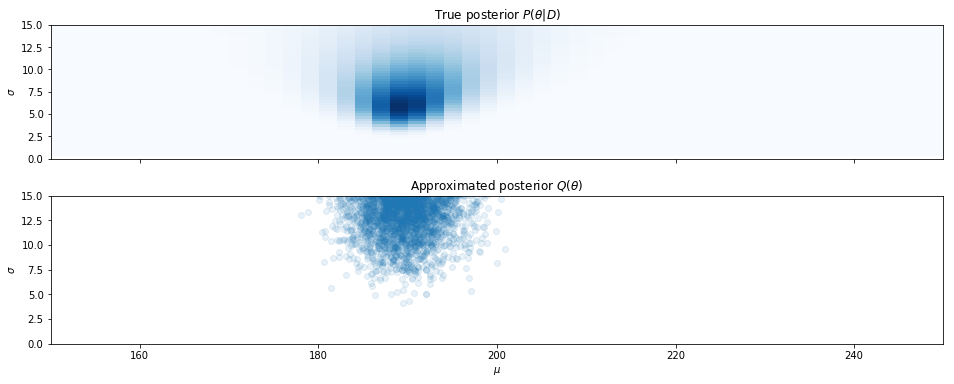

In [73]:
sigma = dist.Chi2(pyro.param('var_sig')).sample((10000,)).numpy()
mu = dist.Normal(pyro.param('var_mu'), pyro.param('var_mu_sig')).sample((10000,)).numpy()

fig, axes = plt.subplots(2, sharex=True, sharey=True, figsize = (16, 6))
axes[0].imshow(posterior, cmap='Blues', extent=extent, aspect=1)
axes[0].set_ylabel('$\sigma$')
axes[1].scatter(mu, sigma, alpha=0.1)
axes[1].set_ylabel('$\sigma$')
axes[0].set_title('True posterior $P(\\theta|D)$')
axes[1].set_title('Approximated posterior $Q(\\theta)$')
plt.xlabel('$\mu$')
plt.xlim(150, mm.max())
plt.ylim(0, ss.max())